In [2]:
import pandas as pd
import numpy as np
from  statsmodels.tsa.api import SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error

In [3]:
def mse(y_true, y_pred):
    return np.mean(np.square(y_true-y_pred))

class myExpSmoothing:
    def __init__(self, y, alpha):
        self.alpha = alpha
        self.y0 = y[0]
        self.data = np.zeros(len(y))
        self.data[0] = self.y0
        
        for i in np.arange(1,len(y)):
            self.data[i] = self.predict(y[i-1], self.data[i-1])
    def predict(self, val_real, val_pred):    
        return self.alpha * val_real + (1-self.alpha) * val_pred

# The algerian export data

In [32]:
index=pd.date_range(start="1960", end="2018", freq="Y")
df=pd.read_csv('AlgeriaExport.txt',header=None).set_index(index)
numpy_df = df.to_numpy().flatten()
numpy_df

array([39.0431726 , 46.24455689, 19.79387268, 24.68468205, 25.08405873,
       22.60394356, 25.98619752, 23.43441677, 23.1356346 , 23.78877682,
       22.0727334 , 18.44251915, 20.44956198, 25.503663  , 38.74904361,
       33.68893622, 33.05458393, 30.58656693, 25.53583672, 31.14830021,
       34.33846147, 34.58725077, 30.92485632, 27.94180611, 25.71001618,
       23.58393289, 12.85475734, 14.27247473, 15.50786788, 18.63926334,
       23.44368508, 29.11782217, 25.31959428, 21.783877  , 22.53072525,
       26.19477598, 29.76044833, 30.90631138, 22.57835401, 28.1501165 ,
       42.06971832, 36.68930475, 35.50453311, 38.24882911, 40.0532265 ,
       47.20519324, 48.81068822, 47.06816355, 47.97334514, 35.37165064,
       38.44454785, 38.78695388, 36.89054757, 33.20989779, 30.21911743,
       23.17177829, 20.86001063, 22.63888685])

For $\alpha =$0.050 the mse - stat is 85.666 and mse - mine is 93.646
For $\alpha =$0.060 the mse - stat is 82.693 and mse - mine is 89.485
For $\alpha =$0.070 the mse - stat is 80.023 and mse - mine is 85.906
For $\alpha =$0.080 the mse - stat is 77.590 and mse - mine is 82.753
For $\alpha =$0.090 the mse - stat is 75.354 and mse - mine is 79.929
For $\alpha =$0.100 the mse - stat is 73.280 and mse - mine is 77.368
For $\alpha =$0.110 the mse - stat is 71.342 and mse - mine is 75.020
For $\alpha =$0.120 the mse - stat is 69.519 and mse - mine is 72.846
For $\alpha =$0.130 the mse - stat is 67.794 and mse - mine is 70.819
For $\alpha =$0.140 the mse - stat is 66.154 and mse - mine is 68.917
For $\alpha =$0.150 the mse - stat is 64.591 and mse - mine is 67.122
For $\alpha =$0.160 the mse - stat is 63.096 and mse - mine is 65.422
For $\alpha =$0.170 the mse - stat is 61.665 and mse - mine is 63.809
For $\alpha =$0.180 the mse - stat is 60.295 and mse - mine is 62.275
For $\alpha =$0.190 

Text(0.5, 1.0, 'Model parameter $\\alpha$ optimization')

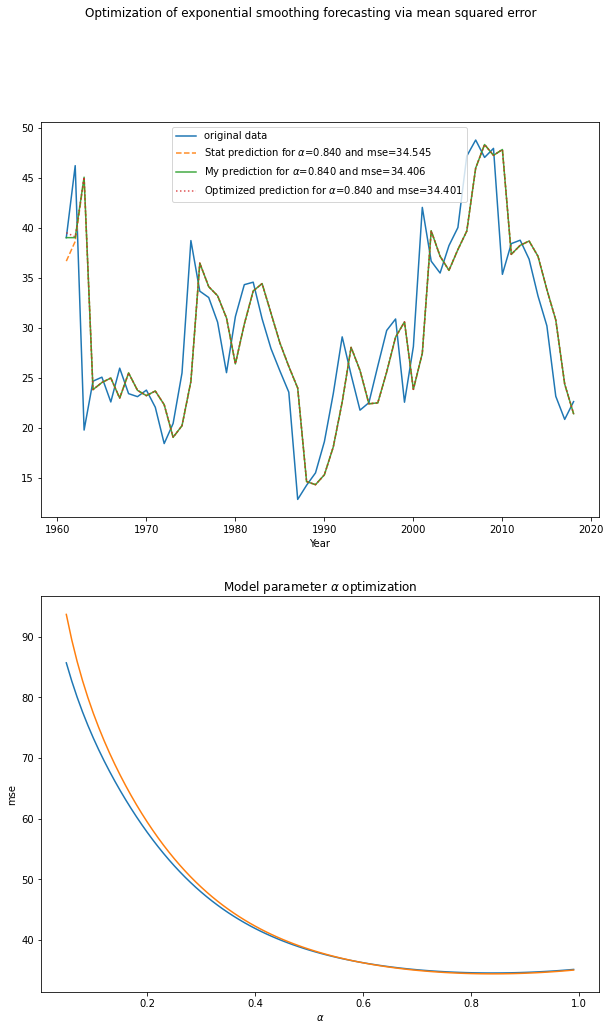

In [33]:
fig, ax = plt.subplots(2, figsize = (10,16))
plt.suptitle("Optimization of exponential smoothing forecasting via mean squared error")

alpha_min_stat = [-1, 1e18]
alpha_min_mine = [-1, 1e18]

bestFitMine = None
bestFitStat = None
alphas = np.arange(0.05,1,0.01)

mses_stat = []
mses_mine = []

# sweep through all alphas
for alpha in alphas:
    fit = SimpleExpSmoothing(df,initialization_method="heuristic").fit(smoothing_level=alpha,optimized=False).fittedvalues
    fitMine = myExpSmoothing(numpy_df, alpha).data
    #fcast = fit.forecast(3).rename(f"$\alpha = {alpha} $")
    mse_stat = mean_squared_error(fit, numpy_df)
    mse_mine = mean_squared_error(fitMine, numpy_df)
    
    mses_stat.append(mse_stat)
    mses_mine.append(mse_mine)
    
    print(r"For $\alpha =$"+ f"{alpha:.3f} the mse - stat is {mse_stat:.3f} and mse - mine is {mse_mine:.3f}")
    if mse_mine < alpha_min_mine[1]: 
        alpha_min_mine = [alpha, mse_mine]
        bestFitMine = fitMine
    if mse_stat < alpha_min_stat[1]: 
        alpha_min_stat = [alpha, mse_stat]
        bestFitStat = fit        
        
# make optimized prediction from the library
fit = SimpleExpSmoothing(df,initialization_method="estimated").fit()       
a=fit.model.params["smoothing_level"]
m=mse(fit.fittedvalues, numpy_df)

# plot 
ax[0].plot(df.index, numpy_df, label = 'original data')
ax[0].plot(df.index, bestFitStat, '--', alpha=0.9, label = r'Stat prediction for $\alpha$=' + f'{alpha_min_stat[0]:.3f} and mse={alpha_min_stat[1]:.3f}')
ax[0].plot(df.index, bestFitMine, '-', alpha=0.9, label = r'My prediction for $\alpha$=' + f'{alpha_min_mine[0]:.3f} and mse={alpha_min_mine[1]:.3f}')
ax[0].plot(df.index, fit.fittedvalues, ':', alpha=0.8, label = r'Optimized prediction for $\alpha$=' + f'{a:.3f} and mse={m:.3f}')
ax[0].legend()
ax[0].set_xlabel("Year")

ax[1].plot(alphas, mses_stat, label = 'from statsmodel')
ax[1].plot(alphas, mses_mine, label = 'from mymodel')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel("mse")
ax[1].set_title(r"Model parameter $\alpha$ optimization")

# IBM

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,6.978967,7.087317,6.978967,7.068196,1.577106,674670
1962-02-02,7.068196,7.112811,7.036329,7.112811,1.587062,533460
1962-05-02,7.112811,7.112811,6.985341,7.023582,1.567152,329490
1962-06-02,7.023582,7.036329,6.998088,7.029955,1.568787,274575
1962-07-02,7.036329,7.074570,7.036329,7.036329,1.570211,266730
...,...,...,...,...,...,...
1965-06-12,8.070427,8.102294,7.934990,7.998725,1.791781,1041816
1965-07-12,8.026609,8.142129,8.026609,8.102294,1.814982,407940
1965-08-12,8.134162,8.205864,8.134162,8.150096,1.825689,395388


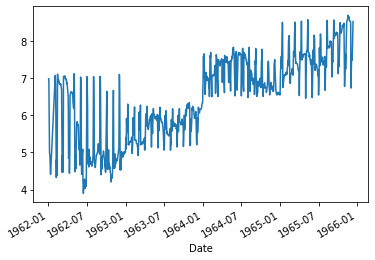

In [4]:
ibm = pd.read_csv('IBM.csv', index_col=['Date'],parse_dates = True)
ibm['Open'].plot()
#
ibm


1962-11-16 00:00:00


<AxesSubplot:xlabel='Date'>

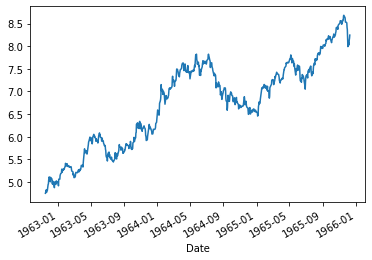

In [83]:
# linear part
timestart = datetime.datetime(1962,11,16)

timeend = datetime.datetime(1966,1,1)
print(timestart)
ibm_linear = ibm[timestart:timeend]
ibm_linear['Open'].plot()#.loc[mask]['Open'].plot()

	->mse with SES = 0.003608269773944319
 	->mse with Holt = 0.0035917694786575293

 	Holt  WINS!!!


C:\Users\maxgr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\maxgr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


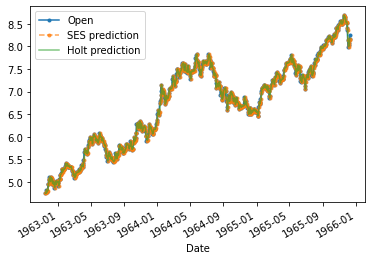

In [104]:
#set new frequency with ffill to get rid of the nans
ibmD = ibm_linear.resample('B').fillna('ffill')

fitSES = SimpleExpSmoothing(ibm_linear['Open'],initialization_method="estimated").fit()
fitHOLT = Holt(ibm_linear['Open'], exponential=True, initialization_method="estimated").fit()
fittedSES = fitSES.fittedvalues
fittedHOLT = fitHOLT.fittedvalues
mseSes = mean_squared_error(ibm_linear['Open'], fittedSES)
mseHolt = mean_squared_error(ibm_linear['Open'], fittedHOLT)
print(
    f"\t->mse with SES = {mseSes}\n",
    f"\t->mse with Holt = {mseHolt}\n\n",
    f"\t{'Holt ' if mseSes>mseHolt else 'SES'} WINS!!!"
    )
fig,ax = plt.subplots()
ibm_linear['Open'].plot(style = '.-',ax = ax)
ax.plot(fittedSES, '.--', alpha=0.7, label = r'SES prediction')
ax.plot(fittedHOLT, '-', alpha=0.6, label = r'Holt prediction')
ax.legend()
#ax.set_xlabel("Year")